## An example on how to convert a MaxCut problem to QUBO (and to Ising)

This code follows the MaxCut QAOA implementation done by Duong Bui

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp

Define MaxCut adjacency matrix

In [5]:
adjacency_matrix = [[0, 1, 1, 1, 1, 1],
                    [1, 0, 0, 1, 0, 0],
                    [1, 0, 0, 1, 0, 0],
                    [1, 1, 1, 0, 1, 1],
                    [1, 0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 1, 0]]

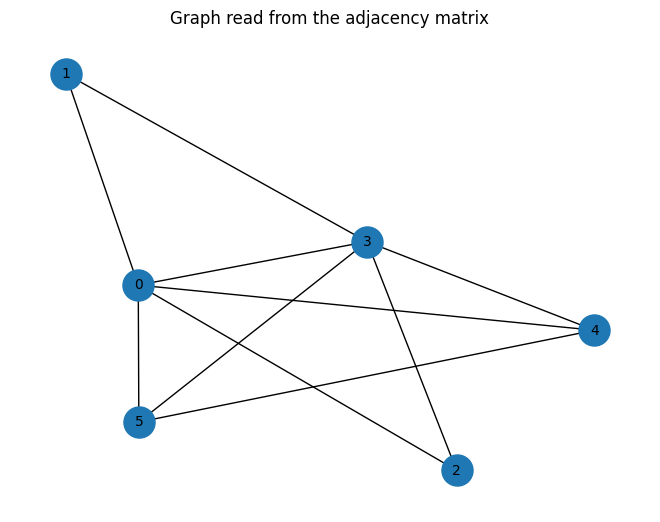

In [7]:
graph = nx.Graph()
vertex_number = len(adjacency_matrix)
vertex_list = []
for i in range(vertex_number):
    vertex_list.append(i)
    for j in range(vertex_number):
        if adjacency_matrix[i][j] == 1:
            graph.add_edge(i, j)

edge_list = list(graph.edges())
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10)
plt.title("Graph read from the adjacency matrix")
plt.show()

Convert adjacency matrix to QUBO matrix

In [8]:
num_nodes = graph.number_of_nodes()
Q = np.eye(num_nodes)

for i in range(len(adjacency_matrix[0])):
    sum = 0
    for j in range(len(adjacency_matrix[0])):
        sum = sum + adjacency_matrix[i][j]
        if adjacency_matrix[i][j] == 1 and not i == j:
            Q[i][j] = 1
    Q[i][i] = -sum

print(Q)

[[-5.  1.  1.  1.  1.  1.]
 [ 1. -2.  0.  1.  0.  0.]
 [ 1.  0. -2.  1.  0.  0.]
 [ 1.  1.  1. -5.  1.  1.]
 [ 1.  0.  0.  1. -3.  1.]
 [ 1.  0.  0.  1.  1. -3.]]


Now this can be converted to for example an Ising Hamiltonian

In [11]:
def convert_qubo_to_ising(qubo):
    # Number of qubits
    n = len(qubo)

    # Calculate the offset also, this is not important for the optimization
    offset = 0
    
    operator_list = []

    for i in range(n):
        for j in range(i, n):
            # Initialize the Pauli operator with all I's
            pauli_operator = list("I"*n)
            
            if i == j:
                pauli_operator[i] = "Z"
                ising_value = -(1/2)*np.sum(qubo[i])
            else:
                pauli_operator[i] = "Z"
                pauli_operator[j] = "Z"
                ising_value = (1/2)*qubo[i][j]

            if not ising_value == 0:
                ising_pauli_op = (''.join(pauli_operator), ising_value)
                operator_list.append(ising_pauli_op)

            offset += (1/2)*qubo[i][j]

    operators = SparsePauliOp.from_list(operator_list)

    return operators

In [12]:
convert_qubo_to_ising(Q)

SparsePauliOp(['ZZIIII', 'ZIZIII', 'ZIIZII', 'ZIIIZI', 'ZIIIIZ', 'IZIZII', 'IIZZII', 'IIIZZI', 'IIIZIZ', 'IIIIZZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j])